In [1]:
#ニューラルネットワーク
#入力x1,x2,,,,に対してw1x1+w2x2+,,,がΘを超えたら1超えなければ0を出力（つまりy=1(w1x1+w2x2+,,,+b)>=0, y=0(w1x1+w2x2+,,,+b)<0)）
#関数はシグモイド関数を使って表す

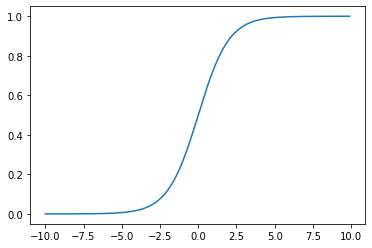

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.arange(-10, 10, 0.1)
plt.plot(x, sigmoid(x))

In [5]:
import torch
#orゲート
#入力
X = torch.Tensor([[0,0],[0,1],[1,0],[1,1]]) #[x1,x2]
#正解データ
t = torch.Tensor([[0],[1],[1],[1]])
#入力が[0,0]のとき出力が0.それ以外はすべて1になる
X

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])

In [6]:
t

tensor([[0.],
        [1.],
        [1.],
        [1.]])

In [11]:
from torch import nn

model = nn.Sequential(
    nn.Linear(2,1), #入力2,出力1
    nn.Sigmoid()
)

In [13]:
y = model(X)
y

#正解とは全然違う値が返る

tensor([[0.4745],
        [0.5271],
        [0.3972],
        [0.4485]], grad_fn=<SigmoidBackward>)

In [14]:
#学習させる
##平均二乗誤差　E（w1, w2, b）=1/4Σ(tn-yn)^2を最小化するようにw1, w2, bを学習させる。
##このEを損失関数という。
##勾配降下法（各パラメータの偏微分を使う）　w1←w1-η*(w1の偏微分)　η(エータ):学習率

from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.1)

In [16]:
loss_fn = nn.MSELoss()
loss_fn(y, t)

tensor(0.2791, grad_fn=<MseLossBackward>)

In [17]:
model.train()
for epoch in range(5000):
    optimizer.zero_grad() # 一度計算された勾配結果を0にリセット
    y = model(X)
    loss = loss_fn(y, t) #平均二乗誤差
    
    loss.backward() #傾きを計算
    optimizer.step()

C:\Users\owner\anaconda3\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


In [18]:
model(X)

tensor([[0.1208],
        [0.9259],
        [0.9258],
        [0.9991]], grad_fn=<SigmoidBackward>)

In [19]:
loss_fn(model(X), t)

tensor(0.0064, grad_fn=<MseLossBackward>)

In [20]:
#XORゲート
#入力
X = torch.Tensor([[0,0],[0,1],[1,0],[1,1]]) #[x1,x2]
#正解データ
t = torch.Tensor([[0],[1],[1],[0]])

model = nn.Sequential(
    nn.Linear(2,1), #入力2,出力1
    nn.Sigmoid()
)

optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()
loss_fn(y, t)

model.train()
for epoch in range(5000):
    optimizer.zero_grad() # 一度計算された勾配結果を0にリセット
    y = model(X)
    loss = loss_fn(y, t) #平均二乗誤差
    
    loss.backward() #傾きを計算
    optimizer.step()

In [21]:
model(X) #一本の直線で1と0を分離できないため学習できない→間に層を入れて値を変換し、分離できるようにする→Deep Learning

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SigmoidBackward>)

In [23]:
model = nn.Sequential(
    nn.Linear(2,2), #入力2,出力2の層を１つ増やす
    nn.Sigmoid(),
    nn.Linear(2,1), #入力2,出力1
    nn.Sigmoid()
)

y = model(X)

optimizer = optim.SGD(model.parameters(), lr=0.05)
loss_fn = nn.MSELoss()
loss_fn(y, t)

model.train()
for epoch in range(30000):
    optimizer.zero_grad() # 一度計算された勾配結果を0にリセット
    y = model(X)
    loss = loss_fn(y, t) #平均二乗誤差
    
    loss.backward() #傾きを計算
    optimizer.step()

In [24]:
model(X)

tensor([[0.0747],
        [0.9310],
        [0.9310],
        [0.0741]], grad_fn=<SigmoidBackward>)

In [26]:
##競馬データ
import pandas as pd

results = pd.read_pickle('result_addinfo_p.pickle')
horse_data = pd.read_pickle('horse_data.pickle')

In [27]:
from tqdm.notebook import tqdm_notebook as tqdm

class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','R','賞金']]
        self.preprocessing()
        
        
    def preprocessing(self): #特に引数がない場合はselfのみ
        result = self.horse_results.copy()
        #着順の0-9以外の文字を含むデータを除く
        #result = result[-result["R"].astype(str).str.contains("\D")] 
        result["着順"] = result["R"].astype(float)
        result["賞金"].fillna(0, inplace=True)
        result["賞金"] = result["賞金"].astype(float)
        result["日付"] = pd.to_datetime(result["日付"])
        result.drop(["R"],axis=1, inplace=True)
        
        self.horse_results = result
        
    def average(self, horse_id_list, date, n_samples='all'):
        self.horse_results.rename(columns={'着順':'着順_ave','賞金':'賞金_ave'}, inplace=True)
        target_df = self.horse_results.loc[horse_id_list]
        #平均する対象をレース日付以前のうち直近n_samplesのデータのみに限定する（古いデータを反映させないため）
        if n_samples=='all':
            filtered_df = target_df[target_df['日付'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['日付'] < date].\
                sort_values('日付',ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        return filtered_df.groupby(level=0)[['着順_ave','賞金_ave']].mean()
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        #レース結果の同じ日付のかたまりごとに1行ずつhorse_idにひもづくその日付以前の戦績の平均を算出し（average）、
        # レース結果のかたまりにマージする(merge)という意味
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)]) 
        return merged_df

In [68]:
hr = HorseResults(horse_data)
results_5R = hr.merge_all(results, 5)

In [69]:
results_5R["rank"] = results_5R["着順"].map(lambda x:1 if x <4 else 0)
results_5R.drop(["馬名","着順","horse_id","jockey_id"],axis=1, inplace=True)
results_5R

,枠番,馬番,斤量,騎手,単勝,人気,性,齢,体重,体重増減,course_len,weather,race_type,ground_state,date,着順_ave,賞金_ave,rank
202001010101,6,6,54.0,横山武史,16.0,3.0,牝,2,438,4,1800,曇,芝,良,2020-07-25,6.0,0.00,1
202001010101,2,2,54.0,ルメール,1.9,2.0,牡,2,510,0,1800,曇,芝,良,2020-07-25,5.0,280.00,1
202001010101,3,3,54.0,池添謙一,1.8,1.0,牡,2,482,-6,1800,曇,芝,良,2020-07-25,5.0,280.00,1
202001010101,1,1,52.0,亀田温心,22.2,4.0,牝,2,442,0,1800,曇,芝,良,2020-07-25,5.0,70.00,0
202001010101,4,4,54.0,藤岡康太,55.7,5.0,牡,2,426,-8,1800,曇,芝,良,2020-07-25,5.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202010010412,1,1,56.0,中井裕二,114.0,14.0,牡,4,452,-6,1200,曇,芝,重,2020-01-26,8.6,0.00,0
202010010412,6,12,57.0,黛弘人,110.9,13.0,牡,5,472,-4,1200,曇,芝,重,2020-01-26,7.2,0.00,0
202010010412,5,9,54.0,横山武史,5.1,2.0,牝,4,478,10,1200,曇,芝,重,2020-01-26,9.4,153.52,0
202010010412,8,16,54.0,柴田大知,115.3,15.0,牝,4,512,-6,1200,曇,芝,重,2020-01-26,5.2,0.00,0


In [78]:
results_d = pd.get_dummies(results_5R).fillna(0)

In [79]:
results_d.head()

,枠番,馬番,斤量,単勝,人気,齢,体重,体重増減,date,着順_ave,...,weather_曇,weather_雨,weather_雪,race_type_ダート,race_type_芝,race_type_障害,ground_state_不良,ground_state_稍重,ground_state_良,ground_state_重
202001010101,6,6,54.0,16.0,3.0,2,438,4,2020-07-25,6.0,...,1,0,0,0,1,0,0,0,1,0
202001010101,2,2,54.0,1.9,2.0,2,510,0,2020-07-25,5.0,...,1,0,0,0,1,0,0,0,1,0
202001010101,3,3,54.0,1.8,1.0,2,482,-6,2020-07-25,5.0,...,1,0,0,0,1,0,0,0,1,0
202001010101,1,1,52.0,22.2,4.0,2,442,0,2020-07-25,5.0,...,1,0,0,0,1,0,0,0,1,0
202001010101,4,4,54.0,55.7,5.0,2,426,-8,2020-07-25,5.0,...,1,0,0,0,1,0,0,0,1,0


In [90]:
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train =df.loc[train_id_list]
    test = df.loc[test_id_list]
    train.drop(['date'],axis=1,inplace=True)
    test.drop(['date'],axis=1,inplace=True)
    return train, test


train, test = split_data(results_d)
X_train = train.drop(['rank'], axis=1)
t_train = train['rank']
X_test = test.drop(['rank'], axis=1)
t_test = test['rank']

In [91]:
##ここからDeep Learning
X_train = torch.Tensor(X_train.values)
t_train = torch.Tensor(y_train.values)
X_test = torch.Tensor(X_test.values)
t_test = torch.Tensor(y_test.values)

In [92]:
X_train

tensor([[ 4.,  7., 54.,  ...,  0.,  1.,  0.],
        [ 1.,  1., 54.,  ...,  0.,  1.,  0.],
        [ 2.,  3., 54.,  ...,  0.,  1.,  0.],
        ...,
        [ 8., 15., 54.,  ...,  0.,  1.,  0.],
        [ 4.,  8., 52.,  ...,  0.,  1.,  0.],
        [ 3.,  5., 54.,  ...,  0.,  1.,  0.]])

In [93]:
t_train = t_train.reshape(-1, 1) #n*1次元に変換
t_test = t_test.reshape(-1, 1)

In [98]:
t_test

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [99]:
model = nn.Sequential(
    nn.Linear(246, 1), #入力246(X_trainのカラム数),出力1
    nn.Sigmoid()
)

In [100]:
model(X_train)

tensor([[0.1297],
        [0.5385],
        [0.9999],
        ...,
        [0.8484],
        [0.9999],
        [0.9999]], grad_fn=<SigmoidBackward>)

In [101]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

model.train()
for epoch in tqdm(range(100)):
    optimizer.zero_grad() # 一度計算された勾配結果を0にリセット
    y = model(X_train)
    loss = loss_fn(y, t_train) #平均二乗誤差
    
    loss.backward() #それぞれのパラメータについて傾きを計算
    optimizer.step() #勾配降下法に基づきパラメータを更新

In [102]:
model(X_train)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], grad_fn=<SigmoidBackward>)

In [103]:
#層を足してみる
model = nn.Sequential(
    nn.Linear(246, 128), #入力246(X_trainのカラム数),出力128
    nn.Sigmoid(),
    nn.Linear(128, 1), #入力128,出力1
    nn.Sigmoid()
)

In [104]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

model.train()
for epoch in tqdm(range(100)):
    optimizer.zero_grad() # 一度計算された勾配結果を0にリセット
    y = model(X_train)
    loss = loss_fn(y, t_train) #平均二乗誤差
    
    loss.backward() #それぞれのパラメータについて傾きを計算
    optimizer.step() #勾配降下法に基づきパラメータを更新

In [105]:
model(X_train)

tensor([[0.2420],
        [0.2258],
        [0.0650],
        ...,
        [0.2578],
        [0.0644],
        [0.0641]], grad_fn=<SigmoidBackward>)

In [106]:
#tensor型をnumpy型に変換
t_train.numpy()

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [107]:
y_train = model(X_train)
y_test = model(X_test)

In [108]:
#モデルを評価
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc_score(t_train.detach().numpy(), y_train.detach().numpy())

0.760611633308764

In [109]:
roc_auc_score(t_test.detach().numpy(), y_test.detach().numpy())

0.7513597116471344